<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/PreisachRNNModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary imports to configure the environment.

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

Getting the Dataset from the Github repository:

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. The values of H and B from the Dataframe are scaled between -1 and 1.

In [ ]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = False

# The scaler is used to rescale the H and B dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B'])
    # Compute the time derivative of H
    temp_data_norm['H_dot'] = np.gradient(temp_data_norm['H'], axis=0)  
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

Roll the signals to let them start from the Saturation value (rolling back $1/4$ of a period)

In [ ]:
# Set the flag to True to let the signals start from the saturation point
start_from_sat = True

if start_from_sat:
    for freq in dataset:
        dataset[freq] = dataset[freq].reindex(np.roll(dataset[freq].index, -len(dataset[freq])//4))

Repeat the signals for a fixed number of times and resample them to a new `resample_fs` (audio sampling frequency: $48 kHz, 96 kHz$)

In [ ]:
import scipy as sp
"""
This method is used to resample the DataFrame signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:param repetitions: if greater than one, the represented curve period is repeated
multiple times
:param resample_fs: frequency to resample the signal to
:param fs: starting sampling frequency
:return: dictionary containing the resampled curves indexed by frequency
"""
def resample_dataset(data, columns, repetitions, resample_fs, fs):
    resampled_dataset = collections.OrderedDict()
    
    for freq in data:
        num_sample = len(data[freq]) * repetitions
        num_sample_sub = int(num_sample / fs * resample_fs)

        resampled_dataset[freq] = pd.DataFrame(sp.signal.resample(np.tile(data[freq], (repetitions, 1)), num_sample_sub), columns=columns)

    return resampled_dataset

In [ ]:
# Resample the dataset signals:
fs = 1e5
resample_fs = 96e3 # or 44.1e3, 48e3, 96e3

repetitions = 2
dataset = resample_dataset(data=dataset,columns=['H', 'B', 'H_dot'], repetitions=repetitions, resample_fs=resample_fs, fs=fs)

Building the *Training Set*. The median frequency curve (H at 20 Hz) is excluded from training and used for validation purposes.

In [ ]:
train_dataset = collections.OrderedDict()

for freq in dataset:
    if freq != 'P2_20Hz.CSV':
        train_dataset[freq] = dataset[freq]

Building the *Validation Set*. It includes the 20 Hz curve.

In [ ]:
val_dataset = collections.OrderedDict()

for freq in dataset:
    if freq == 'P2_20Hz.CSV':
        val_dataset[freq] = dataset[freq]

# PreisachRNN Model Training:

This notebook contains the preliminary tests: different strategies to train the PreisachRNN are here explored, trying to understand how to proceed.

In [ ]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
n_train_signals = len(train_dataset)

### Preisach Memory Layer Definition:

Alternative code version for the Preisach Layer to account for stateful = False training (to be discussed with Alessandro).

In [ ]:
from tensorflow.math import maximum, minimum

class PreisachMemoryLayer(tf.keras.layers.Layer):
    def __init__(self, n_operators, batch_size, stateful, **kwargs):
        super(PreisachMemoryLayer, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.n_operators = n_operators
        self.first_batch = True
        self.stateful = stateful
    
    def build(self, input_shape):
        self.input_dim = input_shape
        self.play_operators = tf.Variable(name='PlayOperators', initial_value=tf.zeros((input_shape[0], input_shape[1], self.n_operators)), trainable=False)
        self.prev_play_operators = tf.Variable(name='PrevPlayOperators', initial_value=tf.zeros((input_shape[0], self.n_operators)), trainable=False) 
        self.r = np.zeros(self.n_operators)
        
        for j in range(self.n_operators):
            # Since the input signal is normalized between -1 and 1, these are also min and max
            self.r[j] = (j / self.n_operators) * (1 - (-1))
        
    def call(self, inputs):
        for t in range(self.input_dim[1]):
            for j in range(self.n_operators):
                if t == 0:
                    if self.first_batch:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], 0))) 
                    else:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.prev_play_operators[:, j])))
                else:
                    self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.play_operators[:, t - 1, j])))
                
        if self.first_batch and self.stateful:
            self.first_batch = False
        
        self.prev_play_operators.assign(self.play_operators[:, t, :])
        
        # The following comment is used as a reference for the Play Operators definition
        # P_j(t) = max(u(t) - r_j, min(u(t) + r_j, P_j(t - 1)))
        # P_j(0) = max(u(0) - r_j, min(u(0) + r_j, k0))
        # r_j = (j - 1)/n * (max(u(t)) - min(u(t)))  j = 1, ..., n
        return self.play_operators
    
    def reset_first_batch(self):
        self.fist_batch = True

## Training with Stateful = True

In [ ]:
# To have cross-batch statefulness set stateful = True
stateful = True

Training batches are created according to the following structure:

```
Batch 0 = [sample_0.5Hz_from_t0_to_t20, sample_1Hz_from_t0_to_t20, ..., sample_1kHz_from_t0_to_t20]

Batch 1 = [sample_0.5Hz_from_t20_to_t40, sample_1Hz_from_t20_to_t40, ..., sample_1kHz_from_t20_to_t40]

Batch 2 = ...
```
Each batch contains samples related to different input frequencies of the dataset, for a total of 10 samples for the training set and 1 sample for the validation set: each sample contains ```seq_len = 20``` timesteps.

The following cell allows to batch also a signal containing the first magnetization curve. The repeated sequences are instead extracted from the portion of the signal which does not contain the first magnetization (namely, the second period of the signal).

In [ ]:
"""
This method is used to create batches from the given dictionary of data
:param data: dictionary containing the curves indexed by frequency
:param include_first_magnetization: if True, both the periods of the curve are used,
including the first magnetization
:param repetitions: if greater than one, the curves are repeated multiple times  
in the batches
:param seq_len: it refers to the length of each input sequence in the batch (must
be a common divider of all the curves lengths)
"""
def create_batches(data, include_first_magnetization=True, repetitions=1, seq_len=20):

    batches = []

    curve_max_len = max([x.shape[0] for x in data.values()]) * repetitions

    for i in range(0, curve_max_len, seq_len):
        batch_X = []
        batch_Y = []
        for freq in data:
            half_length = int(len(data[freq]) / 2)

            index = i % len(data[freq])
            repetition = i // len(data[freq])
        
            if include_first_magnetization:
                if repetition < 1:
                    X = np.array(data[freq].iloc[index : index + seq_len][['H']])
                    Y = np.array(data[freq].iloc[index : index + seq_len][['B']])
                else:
                    # The rep_index is used to not exceed the half length "repetition" array
                    rep_index = index % half_length
                    X = np.array(data[freq].iloc[half_length + rep_index : half_length + rep_index + seq_len][['H']])
                    Y = np.array(data[freq].iloc[half_length + rep_index : half_length + rep_index + seq_len][['B']]) 
            else:
                X = np.array(data[freq].iloc[index : index + seq_len][['H']])
                Y = np.array(data[freq].iloc[index : index + seq_len][['B']])
        
            batch_X.append(X)
            batch_Y.append(Y)
    
        batches.append([batch_X, batch_Y])

    return np.array(batches)

In [ ]:
# Create the batches to be used for model training
repetitions = 1

train_batches = create_batches(train_dataset, repetitions=repetitions)

# Create the batches to be used for model validation
val_batches = create_batches(val_dataset, repetitions=repetitions)

Use the following cells to create the batches in case the first magnetization curve is excluded from the data and resampling at audio frequency is applied.

In [ ]:
import scipy as sp

"""
This method is used to resample and batch the signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:param repetitions: if greater than one, the lowest frequency curve is repeated 
multiple times in the batches, all the other curves are adapted to length
:param resample_f: frequency to resample the signal to
:param fs: starting sampling frequency
:param seq_len: it refers to the length of each input sequence in the batch (must
be a common divider of all the curves lengths)
"""
def resample_and_batch(data, repetitions, resample_fs, fs, seq_len):
    batch_size = len(data)

    num_sample_max = max([x.shape[0] for x in data.values()]) * repetitions
    num_sample_sub = int(num_sample_max / fs * resample_fs)
    
    H_set = np.zeros((batch_size, num_sample_sub))
    B_set = np.zeros((batch_size, num_sample_sub))

    for index, freq in enumerate(data):
        repeat = num_sample_max // len(data[freq])
        H_set[index, :] = sp.signal.resample(np.tile(data[freq]['H'], repeat), num_sample_sub)
        B_set[index, :] = sp.signal.resample(np.tile(data[freq]['B'], repeat), num_sample_sub)       

    batches = []

    for i in range(0, num_sample_sub, seq_len):
        batches.append([H_set[:, i : i + seq_len], B_set[:, i : i + seq_len]])
    
    return np.array(batches)

### Training Set and Validation Set

In [ ]:
# Resample the signals and create the batches:
fs = 1e5
resample_fs = 96e3 # or 44.1e3, 48e3, 96e3

repetitions = 2

# Create the batches to be used for model training
train_batches = resample_and_batch(train_dataset, repetitions=repetitions, resample_fs=resample_fs, fs=fs, seq_len=seq_len)

# Create the batches to be used for model validation
val_batches = resample_and_batch(val_dataset, repetitions=1, resample_fs=resample_fs, fs=fs, seq_len=seq_len)

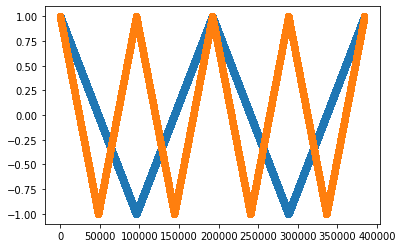

In [ ]:
#####################
### DEBUG BATCHES ###
#####################

x1_axis = []
x2_axis = []
x3_axis = []
x4_axis = []


for batch in train_batches:
    x1_axis.append(batch[0][0])

    x2_axis.append(batch[0][1])

    x3_axis.append(batch[0][2])

    x4_axis.append(batch[0][3])


plt.figure()
plt.scatter(np.arange(0, 384000, 1), x1_axis)
plt.scatter(np.arange(0, 384000, 1), x2_axis)
plt.scatter(np.arange(0, 384000, 1), x3_axis)
plt.scatter(np.arange(0, 384000, 1), x4_axis)

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H (InputLayer)                 [(10, 20, 1)]        0           []                               
                                                                                                  
 H_dot (InputLayer)             [(10, 20, 1)]        0           []                               
                                                                                                  
 PreisachMemoryLayer_10 (Preisa  (10, 20, 6)         1260        ['H[0][0]']                      
 chMemoryLayer)                                                                                   
                                                                                                  
 ConcatenateLayer (Concatenate)  (10, 20, 8)         0           ['H[0][0]',            

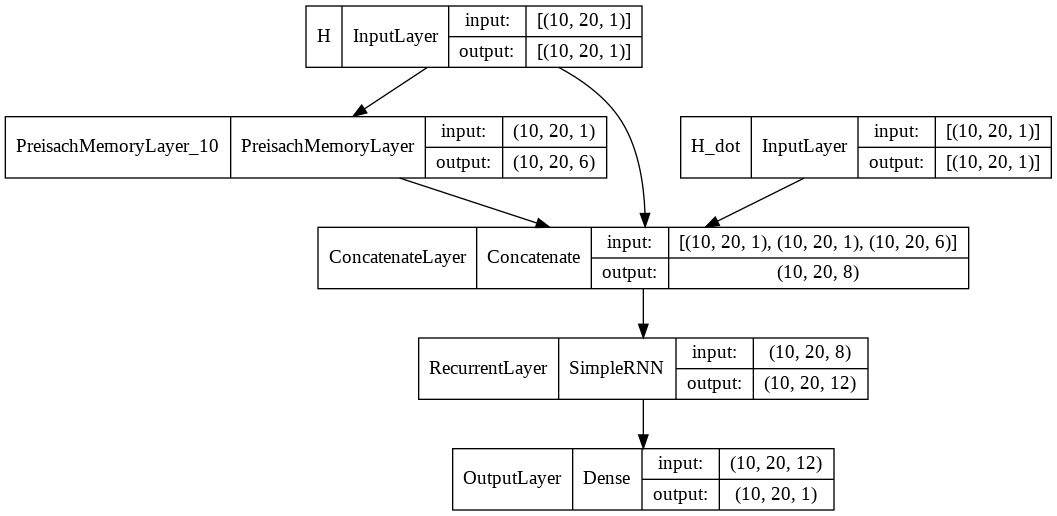

In [ ]:
# Example: building a PreisachRNN using the custom Layer to implement Preisach Memory 
batch_size = n_train_signals
return_sequences = True

# Setting the number of Hidden Neurons to be used by the model
rnn_units = 12
# Setting the number of Play Operators to be used by the model
n_operators = 6

H = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H')
H_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators,
                                     batch_size=batch_size, 
                                     name=f"PreisachMemoryLayer_{batch_size}")(H)

concatenate = tf.keras.layers.concatenate([H, H_dot, preisach_layer], name='ConcatenateLayer')

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units,
                                            return_sequences=return_sequences,
                                            stateful=stateful,
                                            name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


model = tf.keras.Model(inputs=[H, H_dot], outputs=outputs, name='PreisachRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### Batch Training (10 sequences per batch, one for each frequency):
The model is trained with a "stateful" RNN layer.

Weights are tuned after each batch of samples, which include different frequencies.

In [ ]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 10

training_history = {}
validation_history = {}

for epoch in range(num_epochs):
    print('Epoch:' + ' ' + str(epoch+1))
    print('Training...')
    for index, batch in enumerate(train_batches):
        print('\t' + f"Batch {index}:")
        metrics = model.train_on_batch(x=[batch[0], np.gradient(batch[0], axis=1)], y=batch[1], return_dict=True)
        print('\t' + '  ' + 'Loss: ' + str(metrics['loss']))
        print('\t' + '  ' + 'MAE: ' + str(metrics['mean_absolute_error']))
    training_history[epoch] = metrics['loss']
    '''
    print('Validation...')
    for index, batch in enumerate(val_batches):
        print('\t' + f"Batch {index}:")
        metrics = model.test_on_batch(x=[batch[0], np.gradient(batch[0], axis=1)], y=batch[1], return_dict=True)
        print('\t' + '  ' + 'Val_Loss: ' + str(metrics['loss']))
        print('\t' + '  ' + 'Val_MAE: ' + str(metrics['mean_absolute_error']))
    validation_history[epoch] = metrics['loss']
    '''
    if stateful:
        model.reset_states()
        model.get_layer(f'PreisachMemoryLayer_{batch_size}').reset_first_batch
print("--------")  

Plot the Training and Validation Loss


In [ ]:
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xlabel("Epochs")
plt.plot(list(training_history.keys()), list(training_history.values()), label='Loss')
plt.plot(list(validation_history.keys()), list(validation_history.values()), label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

## Training with Stateful = False

In [ ]:
# To avoid cross-batch statefulness set stateful = False
stateful = False

The WindowGenerator Class can:

1. Handle the indexes and offsets.
2. Split windows of features into (features, labels) pairs.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Datasets`.

The following code is inspired from https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               label_columns=None, feature_columns=None, columns=None, 
               sequence_stride=1, batch_size=1):

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.feature_columns = feature_columns
        self.column_indices = {name: i for i, name in
                           enumerate(columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # This customization allows to select the features to use as input, by properly setting
        # the feature_columns argument   
        if self.feature_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=self.sequence_stride,
                shuffle=False,
                batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

The window extracts sequences spaced one sample:
```
[[sample[t0], sample[t1], ... sample[t_seq_len]], [sample[t1], sample[t2], ..., sample[t_seq_len + 1]], ...] 
```



In [ ]:
# Setting the batch generation parameters
seq_per_signal = 4

# Setting the Window Generator parameters
batch_size = 1 # Internal batch_size for the Window Generator
sequence_stride = 1 # Sample distance between successive sequences
seq_len = 20 # The length of the Input sequence
label_width = 1 # The length of the Label sequence

# Instantiating a window class
sequence_window = WindowGenerator(
    input_width=seq_len, label_width=label_width, shift=0,
    label_columns=['B'], feature_columns=['H', 'H_dot'], columns=['H', 'B', 'H_dot'],
    sequence_stride=sequence_stride, batch_size=batch_size)

sequence_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [19]
Label column name(s): ['B']

### Training Set

In [55]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (tf.squeeze(tf.expand_dims(features[:, :, 0], axis=-1), axis=0), tf.squeeze(tf.expand_dims(features[:, :, 0], axis=-1), axis=0))

def get_y_data(features, labels):
    return tf.squeeze(labels, axis=0)

def concat(*ds_elements):
    if type(ds_elements[0]) is tuple:
        #Create one empty list for each component of the dataset
        lists = [[] for _ in ds_elements[0]]
        for element in ds_elements:
            for i, tensor in enumerate(element):
                #For each element, add all its component to the associated list
                lists[i].append(tensor)
                #Concatenate each component list
        return tuple(tf.concat(l, axis=0) for l in lists)
    else:
        return tf.concat(ds_elements, axis=0)    

for freq in train_dataset:
    x_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_x_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())
    y_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_y_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())

train_x_data = tf.data.Dataset.zip(tuple(x_data_list))
train_x_data = train_x_data.map(concat)

train_y_data = tf.data.Dataset.zip(tuple(y_data_list))
train_y_data = train_y_data.map(concat)

train_data = tf.data.Dataset.zip((train_x_data, train_y_data))

### Validation Set

In [57]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (features[:, :, 0], features[:, :, 1])

def get_y_data(features, labels):
    return labels

for freq in val_dataset:
    x_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_x_data))
    y_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_y_data))

val_x_data = tf.data.Dataset.zip(tuple(x_data_list))
val_x_data = val_x_data.map(concat)

val_y_data = tf.data.Dataset.zip(tuple(y_data_list))
val_y_data = val_y_data.map(concat)

val_data = tf.data.Dataset.zip((val_x_data, val_y_data))

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H (InputLayer)                 [(40, 20, 1)]        0           []                               
                                                                                                  
 H_dot (InputLayer)             [(40, 20, 1)]        0           []                               
                                                                                                  
 PreisachMemoryLayer_40 (Preisa  (40, 20, 6)         5040        ['H[0][0]']                      
 chMemoryLayer)                                                                                   
                                                                                                  
 ConcatenateLayer (Concatenate)  (40, 20, 8)         0           ['H[0][0]',            

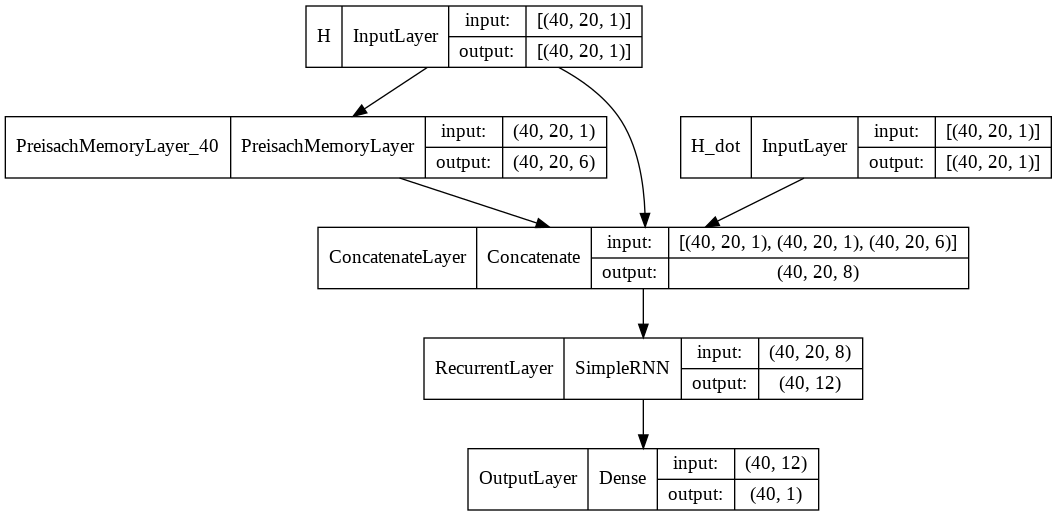

In [59]:
# Example: building a PreisachRNN using the custom Layer to implement Preisach Memory 
batch_size = n_train_signals * seq_per_signal
return_sequences = False

# Setting the number of Hidden Neurons to be used by the model
rnn_units = 12
# Setting the number of Play Operators to be used by the model
n_operators = 6

H = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H')
H_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='H_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators, 
                                     batch_size=batch_size,
                                     stateful=stateful, 
                                     name=f"PreisachMemoryLayer_{batch_size}")(H)

concatenate = tf.keras.layers.concatenate([H, H_dot, preisach_layer], name='ConcatenateLayer')

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units,
                                            return_sequences=return_sequences,
                                            stateful=stateful, 
                                            name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


model = tf.keras.Model(inputs=[H, H_dot], outputs=outputs, name='PreisachRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [61]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### Batch Training (`n_train_signals × seq_per_signal` sequences per batch, with `seq_per_signal` sequences for each frequency):
The model is trained with a either with "stateless" RNN layer.

In [62]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 10

model.fit(train_data, epochs=num_epochs, steps_per_epoch=40000)

Epoch 1/10
40000/40000 [==============================] - 728s 13ms/step - loss: 0.0169 - mean_absolute_error: 0.0617
Epoch 2/10
40000/40000 [==============================] - 599s 15ms/step - loss: 0.0144 - mean_absolute_error: 0.0560
Epoch 3/10
40000/40000 [==============================] - 714s 18ms/step - loss: 0.0128 - mean_absolute_error: 0.0512
Epoch 4/10
40000/40000 [==============================] - 576s 14ms/step - loss: 0.0119 - mean_absolute_error: 0.0488
Epoch 5/10
40000/40000 [==============================] - 683s 17ms/step - loss: 0.0114 - mean_absolute_error: 0.0477
Epoch 6/10
40000/40000 [==============================] - 607s 15ms/step - loss: 0.0112 - mean_absolute_error: 0.0468
Epoch 7/10
40000/40000 [==============================] - 521s 13ms/step - loss: 0.0109 - mean_absolute_error: 0.0459
Epoch 8/10
40000/40000 [==============================] - 684s 17ms/step - loss: 0.0107 - mean_absolute_error: 0.0452
Epoch 9/10
40000/40000 [==============================] 

## Save the Model Weights

Set the model's name and save it.

In [64]:
filename = f'PreisachRNN_{rnn_units}_units_seq_len_{seq_len}_stateful_{stateful}_first_magnetization_{include_first_magnetization}_fs_{resample_fs}_repeated_{repetitions}_epochs_{num_epochs}.h5'

# Saving the model weights
model.save_weights(filename, save_format='h5')

#files.download(filename)

## Prediction Model:

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H (InputLayer)                 [(1, 20, 1)]         0           []                               
                                                                                                  
 H_dot (InputLayer)             [(1, 20, 1)]         0           []                               
                                                                                                  
 PreisachMemoryLayer_1 (Preisac  (1, 20, 6)          126         ['H[0][0]']                      
 hMemoryLayer)                                                                                    
                                                                                                  
 Concatenate (Concatenate)      (1, 20, 8)           0           ['H[0][0]',            

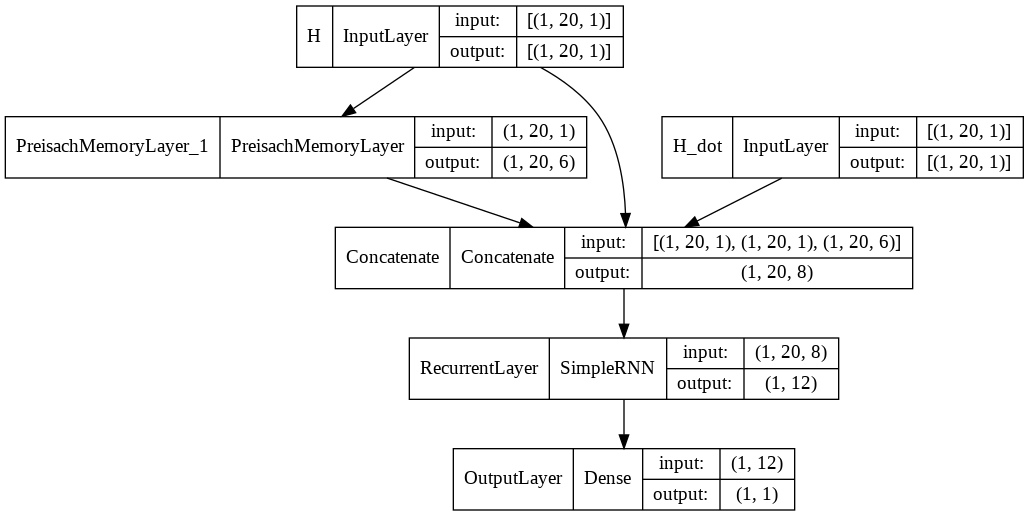

In [65]:
# Instantiating a prediction model to use a different batch size during prediction

# Setting the number of Hidden Neurons to be used by the model
rnn_units = 12

# Setting the number of Play Operators to be used by the model
n_operators = 6

pred_batch_size = 1

H = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=pred_batch_size, name='H')
H_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=pred_batch_size, name='H_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators,
                                     batch_size=pred_batch_size,
                                     stateful=stateful,
                                     name=f"PreisachMemoryLayer_{pred_batch_size}")(H)

concatenate = tf.keras.layers.concatenate([H, H_dot, preisach_layer], name='Concatenate')

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units,
                                            return_sequences=return_sequences,
                                            stateful=stateful,
                                            name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


prediction_model = tf.keras.Model(inputs=[H, H_dot], outputs=outputs, name='PreisachRNN')
prediction_model.summary()

tf.keras.utils.plot_model(prediction_model, show_shapes=True)

Take the weights from the just trained model:

In [66]:
prediction_model.load_weights(filename, by_name=True, skip_mismatch=True)

The following method is used to plot model predictions vs. ground truth, with some additional metrics as MSE and MAE.

In [45]:
prediction_model.load_weights('/content/PreisachRNN_12_units_seq_len_20_stateful_True_first_magnetization_False_fs_96000.0_repeated_2_epochs_10.h5', by_name=True, skip_mismatch=True)

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=2)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

In [ ]:
### DEBUG CELL
predictions = prediction_model.predict(val_data)
plot_prediction(predictions, val_dataset['P2_20Hz.CSV']['B'][seq_len - 1:], val_dataset['P2_20Hz.CSV']['H'][seq_len - 1:], 'P2_20Hz.CSV')

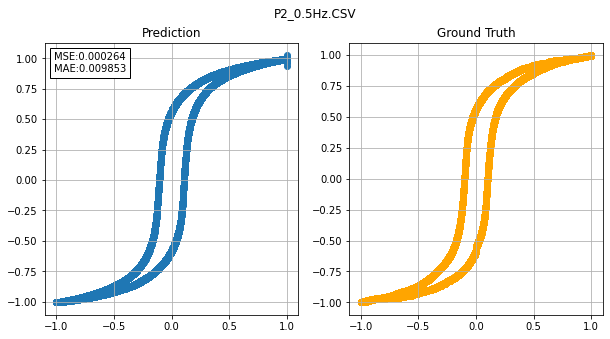

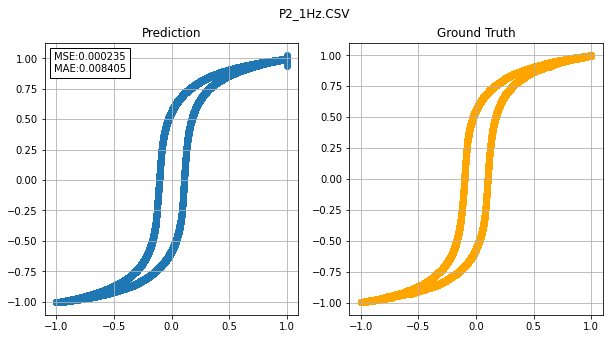

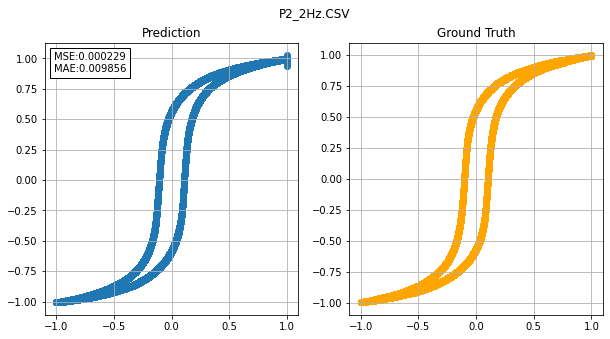

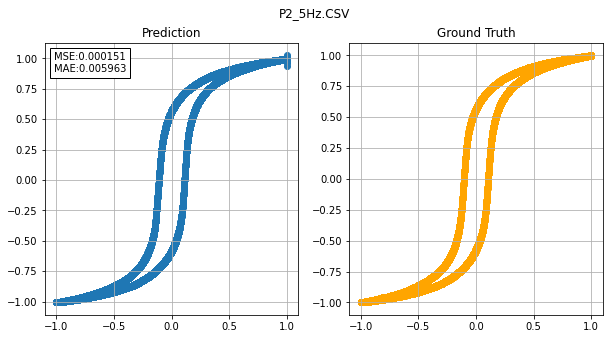

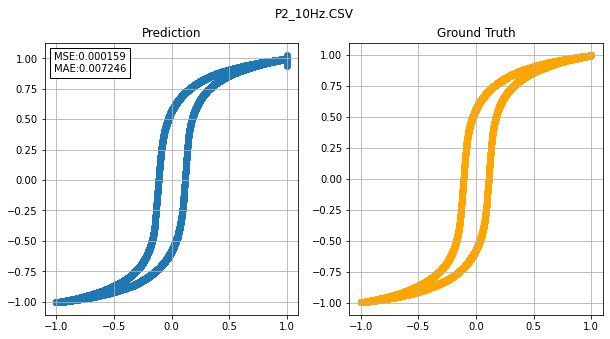

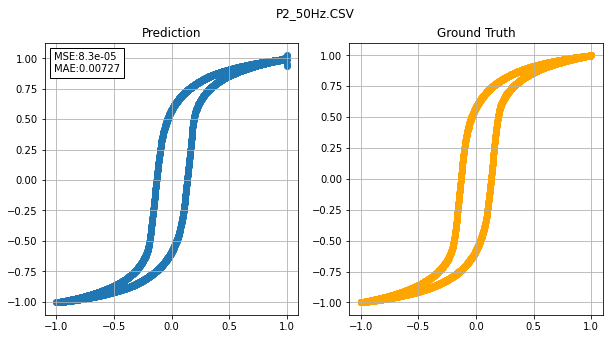

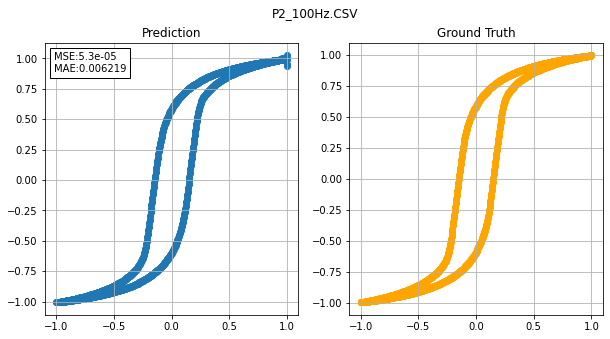

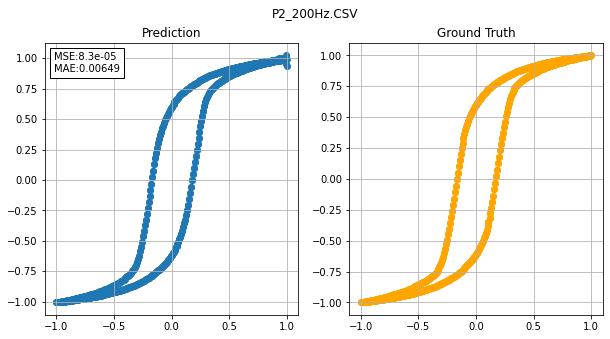

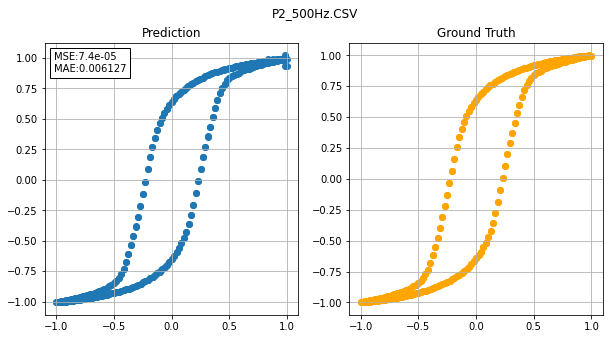

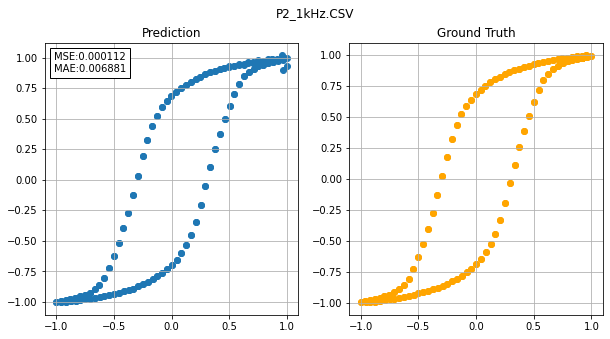

In [ ]:
####### RESAMPLED DATASET ##########
## PREDICTIONS OVER TRAINING DATA ##

# The dictionary contains the predictions for the different frequency signals
model_predictions_train = {}

# Reset the model states before computing the predictions
prediction_model.reset_states()
# Reset the Play Operators
prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch

for freq in train_dataset:
    # The dictionary contains B_pred, B_true, H for each single frequency
    signals = {}

    # The array contains the predictions of B for a given frequency
    B_pred = []
    
    H = np.array(train_dataset[freq]['H'])
    B_true = np.array(train_dataset[freq]['B'])

    # Compute the number of samples to perform signal subsampling
    num_sample_sub = int(len(H) / fs * resample_fs)
    
    # Subsample the signals
    H = sp.signal.resample(np.tile(H, repetitions), num_sample_sub * repetitions)
    B_true = sp.signal.resample(np.tile(B_true, repetitions), num_sample_sub * repetitions)

    # Pad if necessary the signal to fit an integer number of sequences
    if (len(H) % seq_len != 0):
        pad = seq_len - (len(H) % seq_len)
        H = np.pad(H, (0, pad), 'constant', constant_values=H[-1])
        B_true = np.pad(B_true, (0, pad), 'constant', constant_values=B_true[-1])

    # Divide the signal in batches
    H = H.reshape(-1, seq_len)

    # Compute the model predictions
    for batch in H:
        B_pred.append(prediction_model.predict([np.expand_dims(batch, axis=0), np.gradient(np.expand_dims(batch, axis=0), axis=1)]))

    # Reshape batch predictions into a single array
    B_pred = np.array(B_pred).reshape(-1, 1)

    # Store predictions into a dict to be written as a file
    signals['B_pred'] = B_pred.tolist()
    signals['B_true'] = B_true.tolist()
    signals['H'] = H.tolist()

    model_predictions_train[freq] = signals

    # Reset the states after each frequency prediction
    prediction_model.reset_states()
    # Reset the Play Operators
    prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch
    
    plot_prediction(B_pred, B_true, H, freq)

In [ ]:
# Write training prediction file and save    
with open(filename + '_training_predictions.txt', 'w') as file:
     file.write(json.dumps(model_predictions_train))

files.download(filename + '_training_predictions.txt')

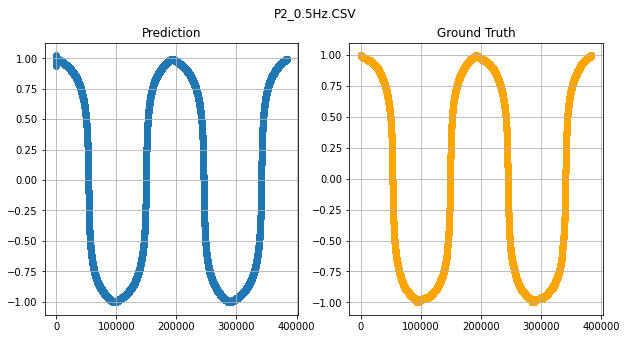

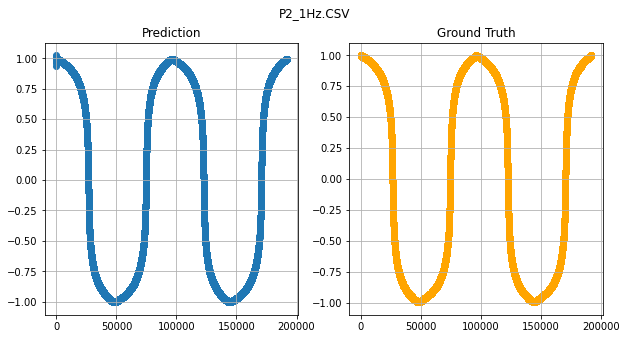

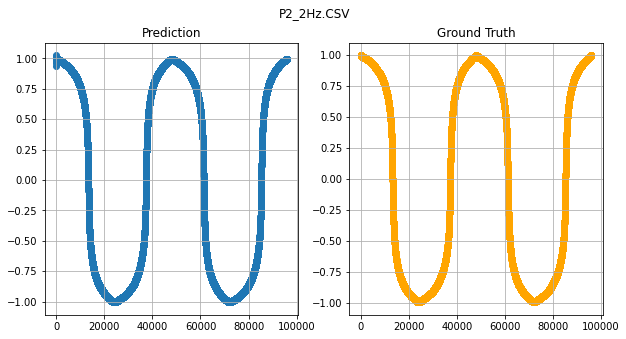

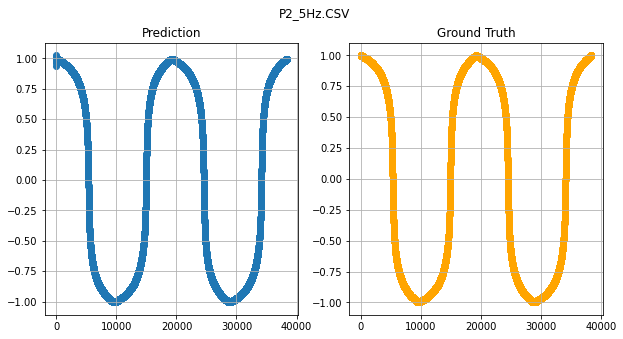

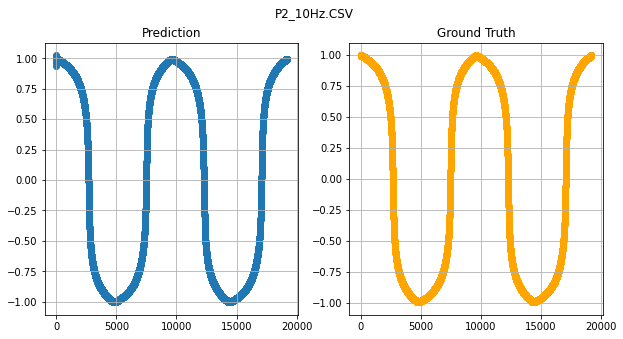

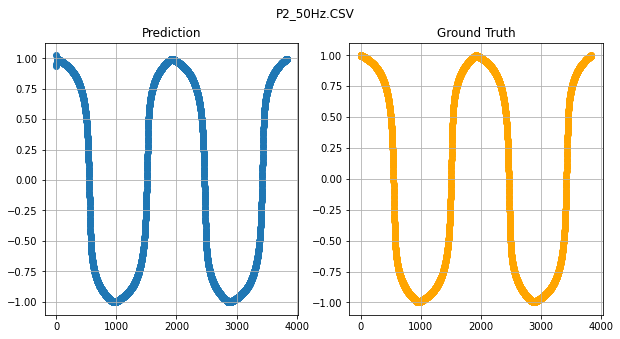

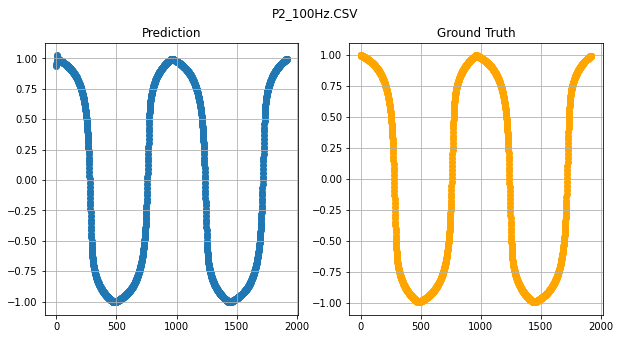

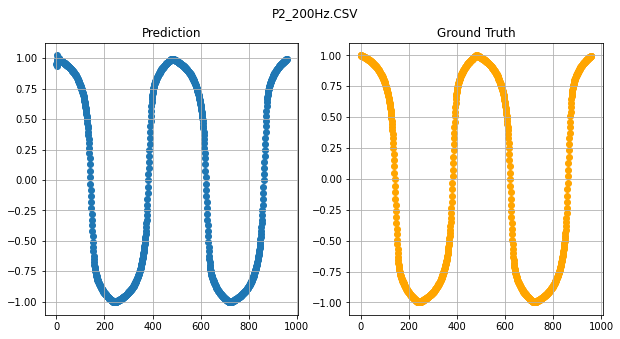

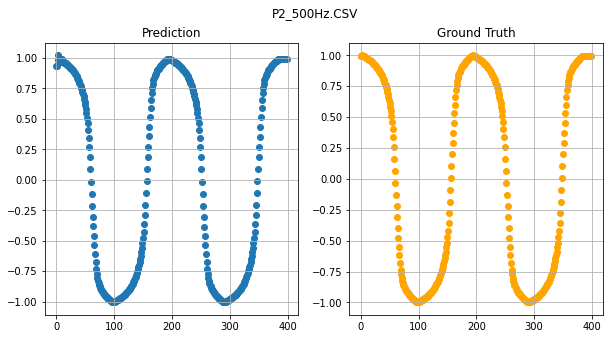

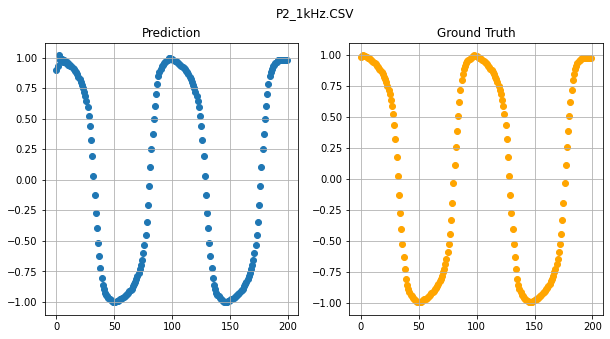

In [ ]:
for freq in model_predictions_train:
    B_true = model_predictions_train[freq]['B_true']
    B_pred = model_predictions_train[freq]['B_pred']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(freq)

    ax1.set_title('Prediction')
    ax1.scatter(np.arange(0, len(B_pred)), B_pred)
    ax1.grid(True)

    ax2.set_title('Ground Truth')
    ax2.scatter(np.arange(0, len(B_true)), B_true, c='orange')
    ax2.grid(True)

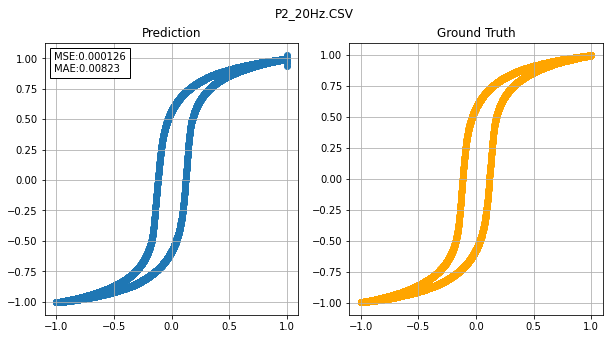

In [ ]:
######## RESAMPLED DATASET ###########
## PREDICTIONS OVER VALIDATION DATA ##

# The dictionary contains the predictions for the different frequency signals
model_predictions_test = {}

# Reset the model states before computing the predictions
prediction_model.reset_states()
# Reset the Play Operators
prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch

for freq in val_dataset:
    # The dictionary contains B_pred, B_true, H for each single frequency
    signals = {}

    # The array contains the predictions of B for a given frequency
    B_pred = []
    
    H = np.array(val_dataset[freq]['H'])
    B_true = np.array(val_dataset[freq]['B'])

    # Compute the number of samples to perform signal subsampling
    num_sample_sub = int(len(H) / fs * resample_fs)
    
    # Subsample the signals
    H = sp.signal.resample(np.tile(H, repetitions), num_sample_sub * repetitions)
    B_true = sp.signal.resample(np.tile(B_true, repetitions), num_sample_sub * repetitions)

    # Pad if necessary the signal to fit an integer number of sequences
    if (len(H) % seq_len != 0):
        pad = seq_len - (len(H) % seq_len)
        H = np.pad(H, (0, pad), 'constant', constant_values=H[-1])
        B_true = np.pad(B_true, (0, pad), 'constant', constant_values=B_true[-1])

    # Divide the signal in batches
    H = H.reshape(-1, seq_len)

    # Compute the model predictions
    for batch in H:
        B_pred.append(prediction_model.predict([np.expand_dims(batch, axis=0), np.gradient(np.expand_dims(batch, axis=0), axis=1)]))

    # Reshape batch predictions into a single array
    B_pred = np.array(B_pred).reshape(-1, 1)

    # Store predictions into a dict to be written as a file
    signals['B_pred'] = B_pred.tolist()
    signals['B_true'] = B_true.tolist()
    signals['H'] = H.tolist()

    model_predictions_test[freq] = signals

    # Reset the states after each frequency prediction
    prediction_model.reset_states()
    # Reset the Play Operators
    prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch
    
    plot_prediction(B_pred, B_true, H, freq)

In [ ]:
# Write test prediction file and save    
with open(filename + '_test_predictions.txt', 'w') as file:
     file.write(json.dumps(model_predictions_test))

files.download(filename + '_test_predictions.txt')

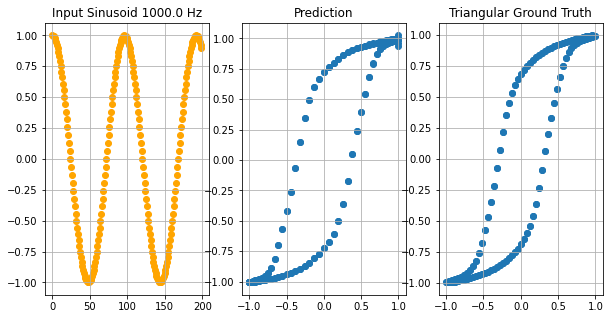

In [ ]:
#### TEST WITH SINUSOIDAL INPUT AT A GIVEN FREQUENCY ######
B_pred = []

fs = 96e3 # sample rate 
f = 1e3 # the frequency of the signal

samples = 2 * fs/f

if samples % seq_len != 0:
    samples = samples + seq_len - (samples % seq_len)

x = np.arange(samples)

# compute the value (amplitude) of the sin wave at the for each sample
input_signal = np.cos(2*np.pi*f * (x/fs))

# Divide the input signal in batches
input_signal = input_signal.reshape(-1, seq_len)

# Reset the model states before computing the predictions
prediction_model.reset_states()
# Reset the Play Operators
prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch


# Compute the model predictions
for batch in input_signal:
    B_pred.append(prediction_model.predict([np.expand_dims(batch, axis=0), np.gradient(np.expand_dims(batch, axis=0), axis=1)]))

# Reshape batch predictions into a single array
prediction = np.array(B_pred).reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title(f'Input Sinusoid {f} Hz')
ax1.scatter(x, input_signal, c='orange')
ax1.grid(True)

ax2.set_title('Prediction')
ax2.scatter(input_signal, prediction)
ax2.grid(True)

H_triang = train_dataset[f"P2_1kHz.CSV"]['H']
B_triang = train_dataset[f"P2_1kHz.CSV"]['B']

# Compute the number of samples to perform signal subsampling
num_sample_sub = int(len(H_triang) / fs * resample_fs)

# Subsample the signals
H_triang = sp.signal.resample(np.tile(H_triang, repetitions), num_sample_sub * repetitions)
B_triang = sp.signal.resample(np.tile(B_triang, repetitions), num_sample_sub * repetitions)

# Pad if necessary the signal to fit an integer number of sequences
if (len(H_triang) % seq_len != 0):
    pad = seq_len - (len(H) % seq_len)
    H_triang = np.pad(H_triang, (0, pad), 'constant', constant_values=H[-1])
    B_triang = np.pad(B_triang, (0, pad), 'constant', constant_values=B_true[-1])

ax3.set_title('Triangular Ground Truth')
ax3.scatter(H_triang, B_triang)
ax3.grid(True)